In [1]:
%load_ext autoreload
%autoreload 2

from spear.flows import TaxableIncome, Expense
from spear.assets import Asset
from spear.model import FinancialModel

In [6]:
salary = TaxableIncome(name="Salary", initial_value=230_000, state="MA")
salary.base_value[4:] = 0 # simulate quiting, should be an Event instead
housing = Expense(name="Housing", initial_value=10_000, inflation_rate=0.02)
cost_of_living = Expense(name="Cost of Living", initial_value=50_000, inflation_rate=0.03)

cash = Asset(name="Cash", initial_value=20_000, growth_rate=0.01, cap_value=50_000)
bonds = Asset(name="Bonds", initial_value=50_000, growth_rate=0.03, allocation=0.1)
stocks = Asset(name="Stocks", initial_value=400_000, growth_rate=0.08, allocation=0.9)
_401k = Asset(name="401k", initial_value=100_000, growth_rate=0.08, cap_deposit=20_000, pretax=True)

In [7]:
planner = FinancialModel(
    revenues=[salary],
    expenses=[housing, cost_of_living],
    assets=[cash, bonds, stocks, _401k],
    duration=28,
    enable_logging=True,
)
planner.run()

2024-10-07 15:06:55,831 - spear.model - INFO - FinancialModel initialized. Start year: 2024
2024-10-07 15:06:55,833 - spear.model - INFO - Starting financial planning simulation
2024-10-07 15:06:55,833 - spear.model - INFO - Processing year 2024
2024-10-07 15:06:55,834 - spear.model - INFO - Revenues: 230_000, Expenses: 60_000, Cash flow for year 2024: 170_000
2024-10-07 15:06:55,835 - spear.model - INFO - Invested in year 2024: 20_000 in 401k
2024-10-07 15:06:55,836 - spear.model - INFO - Withdrew 20_000 from Salary in year 2024
2024-10-07 15:06:55,836 - spear.model - INFO - Taxed 56_532 from Salary in year 2024
2024-10-07 15:06:55,837 - spear.model - INFO - Revenues: 153_468, Expenses: 60_000, Cash flow for year 2024: 93_468
2024-10-07 15:06:55,837 - spear.model - INFO - Positive cash flow in year 2024. Investing surplus.
2024-10-07 15:06:55,838 - spear.model - INFO - Invested in year 2024: 30_000 in Cash
2024-10-07 15:06:55,839 - spear.model - INFO - Invested in year 2024: 6_346.8 i

2024-10-07 15:06:55,887 - spear.model - INFO - Taxed 0 from Salary in year 2032
2024-10-07 15:06:55,888 - spear.model - INFO - Revenues: 0, Expenses: 75_050, Cash flow for year 2032: -75_050
2024-10-07 15:06:55,889 - spear.model - INFO - Negative cash flow in year 2032. Withdrawing funds.
2024-10-07 15:06:55,889 - spear.model - INFO - Withdrew 0 from Cash in year 2032
2024-10-07 15:06:55,890 - spear.model - INFO - Withdrew 0 from Bonds in year 2032
2024-10-07 15:06:55,891 - spear.model - INFO - Withdrew 75_050 from Stocks in year 2032
2024-10-07 15:06:55,893 - spear.model - INFO - Insufficient funds to withdraw 0. Adding debt for next year.
2024-10-07 15:06:55,894 - spear.model - INFO - Processing year 2033
2024-10-07 15:06:55,895 - spear.model - INFO - Revenues: 0, Expenses: 77_184, Cash flow for year 2033: -77_184
2024-10-07 15:06:55,897 - spear.model - INFO - Taxed 0 from Salary in year 2033
2024-10-07 15:06:55,898 - spear.model - INFO - Revenues: 0, Expenses: 77_184, Cash flow for 

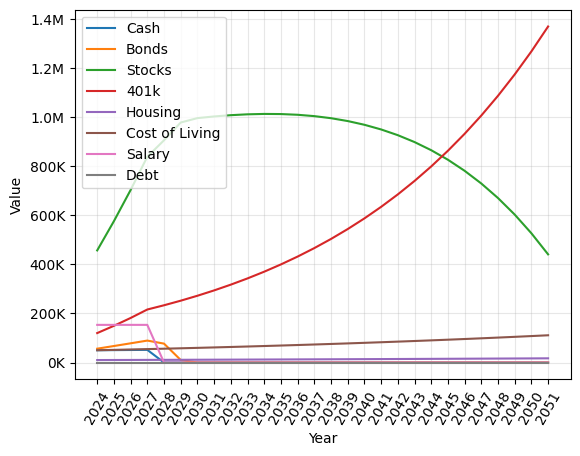

In [8]:
planner.plot_all();